In [1]:
import pandas as pd
import numpy as np

import src.iodata as iodata
import src.preprocess as preproc
import src.markovchain as mchain
import src.visualize as visualize
from matplotlib import pyplot as plt

# XBTUSD

In [2]:
ticker = 'XBTUSD'
df = iodata.get_df(ticker)
# Time resolution is 1ms, so duplicate might occur, keep last.
df = df[~df.index.duplicated(keep='last')]
df['time'] = df['time'].dt.tz_localize(None)
df.index = df.index.tz_localize(None)
df.head(5)

,bs,bid,ask,as,time,mid,sprd,imb,wmid
timestamp,,,,,,,,,
2020-12-14 00:07:24.057,83434.0,19077.0,19077.5,890861.0,2020-12-14 00:07:24.057,19077.25,0.25,0.085635,19077.042818
2020-12-14 00:07:24.072,83434.0,19077.0,19077.5,902353.0,2020-12-14 00:07:24.072,19077.25,0.25,0.084637,19077.042318
2020-12-14 00:07:24.081,83434.0,19077.0,19077.5,906348.0,2020-12-14 00:07:24.081,19077.25,0.25,0.084295,19077.042148
2020-12-14 00:07:24.095,83434.0,19077.0,19077.5,911348.0,2020-12-14 00:07:24.095,19077.25,0.25,0.083872,19077.041936
2020-12-14 00:07:24.097,83434.0,19077.0,19077.5,917348.0,2020-12-14 00:07:24.097,19077.25,0.25,0.083369,19077.041684


In [3]:
n_imb = 10
n_spread = 3
dt = 1
ticker = 'XBTUSD'
df = iodata.get_df(ticker)
df, misc = preproc.discretize(df, n_imb, dt, n_spread)
df = preproc.mirror(df, misc)

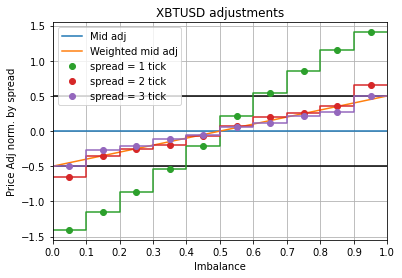

In [4]:
G1, B, Q, Q2, R1, R2, K = mchain.estimate(df)
Gstar, Bstar = mchain.calc_price_adj(G1, B, order='stationary')
visualize.plot_Gstar(ticker, Gstar, misc)

pmf(s = 1 tick) = 0.37
pmf(s = 2 tick) = 0.41
pmf(s = 3 tick) = 0.22


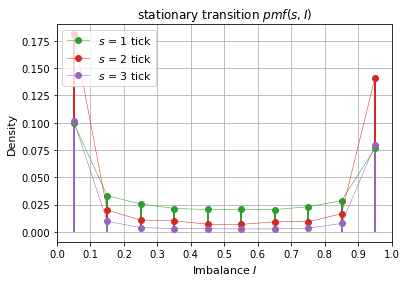

In [5]:
Bstar_pdf = Bstar.iloc[0]  # ~= np.linalg.matrix_power(B,10).iloc[0]
Bstar_pdf = pd.Series(np.linalg.matrix_power(B, 5)[0], index=B.columns)
visualize.plot_Bstar(Bstar_pdf, misc)

In [6]:
from matplotlib import pyplot as plt
tmp = df['dM'].value_counts()
tmp2 = pd.DataFrame(tmp)
tmp2.index.name = 'dM [ticks]'
tmp2.rename(inplace=True, columns={'dM':'count'})
tmp2[tmp2.index > 0].sort_index()

,count
dM [ticks],
0.25,4449
0.50,1712


# Experimental

### LOB range view

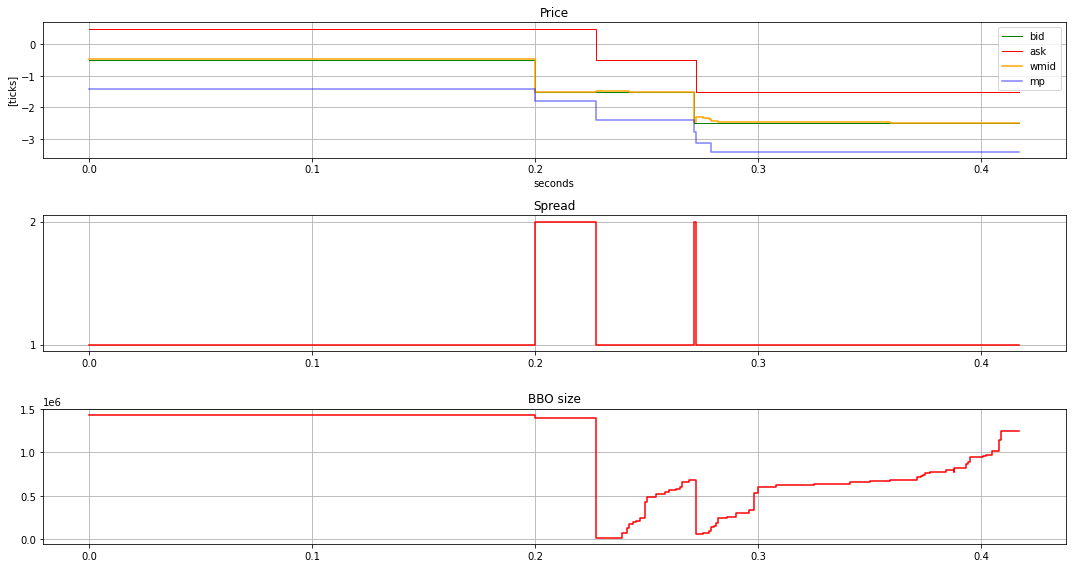

In [7]:
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

events_slice = slice(7130,7200) # events to look at


df['tot_size'] = df['as'] + df['bs']
df['next_tot_size'] = df['next_as'] + df['next_bs']

tmp = pd.DataFrame(Gstar, columns=['micropriceadj'])
df2 = pd.merge(df[~df['mirrored']], tmp, left_on=['spread', 'imb_bucket'], right_index=True, how='inner')
df2['microprice'] = df2['mid'] + df2['micropriceadj']

df2.sort_values(by=['time'], inplace=True)
#view = df2.iloc[1000:3500]
view = df2.iloc[events_slice]

#plt.figure(figsize=(15, 5))
fig, axs = plt.subplots(3, 1, figsize=(15, 8))
#ax = plt.axes()
#ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
for ax in axs[0:2]:
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.grid()
axs[2].grid()

incep = view['time'].iloc[0]
timedelta = (view['time']-incep) / pd.Timedelta('1 seconds')
yoffset = view['mid'].iloc[0]
rel_values = lambda ds:  (ds - yoffset) / misc['ticksize']
axs[0].step(timedelta, rel_values(view['bid']), color='g', label='bid', linewidth=1)
axs[0].step(timedelta, rel_values(view['ask']), color='r', label='ask', linewidth=1)
axs[0].step(timedelta, rel_values(view['wmid']), color='orange', label='wmid')
axs[0].step(timedelta, rel_values(view['microprice']), color='b', alpha=0.5, label='mp')
axs[0].set_title('Price')
axs[0].set_xlabel('seconds')
axs[0].set_ylabel('change [ticksize]')
axs[0].legend()

axs[1].step(timedelta, view['spread'] / misc['ticksize'], color='r', label='spread')
axs[0].set_ylabel('[ticks]')
axs[1].set_title('Spread')

axs[2].step(timedelta, view['tot_size'], color='r', label='spread')
axs[2].set_title('BBO size')

fig.tight_layout()

## Volume at Best Bid

volu|mid↓ mean 33970 median 4559
volu|mid→ mean 737048 median 611974


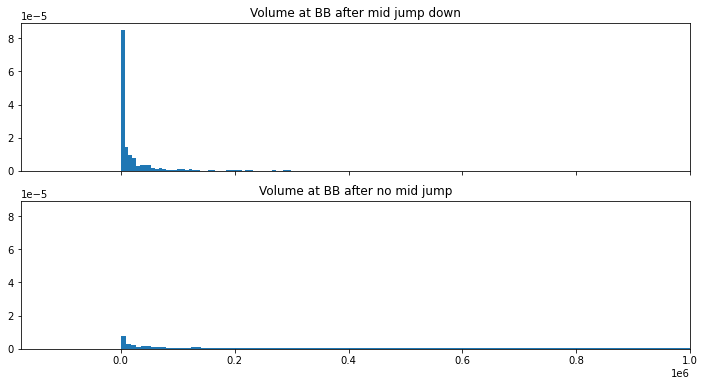

In [8]:
volu_down = df2[df2['dM'] < 0.0]['bs']
print('volu|mid↓', f"mean {volu_down.mean():.0f}", f"median {volu_down.median():.0f}")

volu_flat = df2[df2['dM'] == 0.0]['bs']
print('volu|mid→', f"mean {volu_flat.mean():.0f}", f"median {volu_flat.median():.0f}")

fig, axs = plt.subplots(2, 1, figsize=(12,6), sharex=True, sharey=True)
axs[0].hist(volu_down, density=True, bins=400)
axs[0].set_title('Volume at BB after mid jump down')
axs[1].hist(volu_flat, density=True, bins=400)
axs[1].set_title('Volume at BB after no mid jump')


axs[0].set_xlim([None, 1e6])
#axs[0].set_ylim([None, 1e-4])
#axs[1].set_ylim([None, 1e-5])
plt.show()

## Mid | \{imb, mid↑or↓\}

(0.0, 1.0)

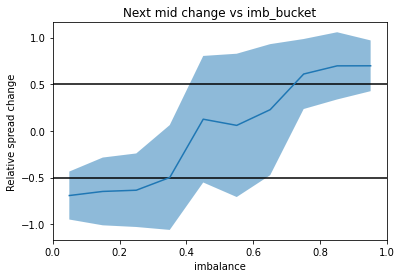

In [9]:

frm = df[~df['mirrored']].copy()
frm['spreadticks'] = (frm['spread'] / misc['ticksize']).round()
frm = frm[frm['spreadticks']==1.0]
frm['dMn'] = frm['dM'] / frm['spread']
view = frm[frm['dMn']!=0.0]
res = view.groupby('imb_bucket')['dMn'].agg(['mean', 'std'])

xx = misc['imb_bucket_mid'][res.index]
plt.figure()
plt.plot(xx, res['mean'])
plt.fill_between(xx, res['mean'] - res['std'], res['mean'] + res['std'], alpha=0.5)
plt.hlines(-0.5, 0, 1, color='k')
plt.hlines(0.5, 0, 1, color='k')
plt.title('Next mid change vs imb_bucket')
plt.xlabel('imbalance')
plt.ylabel('Relative spread change')
plt.xlim([0, 1])

## next_imb | \{imb, mid↑or↓\}
downtrending market, hence mass at low imbalances.

            next_imb          
                mean       std
imb_bucket                    
0           0.145752  0.234999
1           0.303726  0.310574
2           0.342762  0.285938
3           0.419409  0.303517
4           0.523190  0.291716
5           0.629503  0.220087
6           0.692238  0.247654
7           0.674989  0.234917
8           0.853204  0.173619
9           0.863377  0.216403


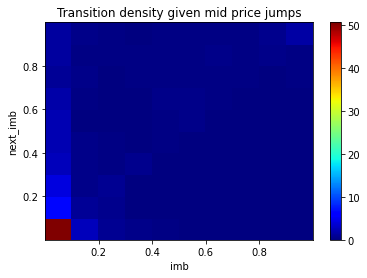

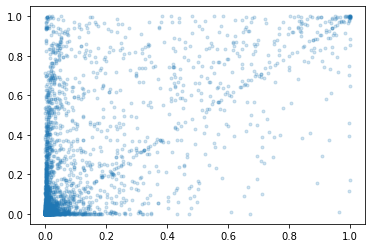

In [10]:
#view = df[(~df['mirrored']) & (df['dM']!=0.0)]

#mask = (~df['mirrored']) & (df['dM']!=0) & (df['dM'].shift(-1) == 0) & (df['dM'].shift(1) == 0)
mask = (~df['mirrored']) & (df['dM']<0.0)
view = df[mask]

x = view['imb']
y = view['next_imb']


fig, ax = plt.subplots()
h = ax.hist2d(x, y, bins=10, density=True, cmap=plt.cm.jet)
fig.colorbar(h[3], ax=ax)
plt.title('Transition density given mid price jumps')
plt.xlabel(x.name)
plt.ylabel(y.name)

plt.figure()
view2 = view[view['imb'] < 1.5]
plt.scatter(view2['imb'], view2['next_imb'], marker='.', alpha=0.2)
view[view['imb'] < 0.25]['next_imb'].mean()



stats = view[['imb_bucket', 'next_imb']].groupby(['imb_bucket']).agg(['mean', 'std'])
print(stats)


Text(0, 0.5, 'next_imb_bucket')

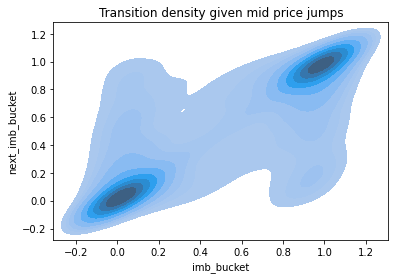

In [11]:
import seaborn as sns
df['tot_size'] = df['as'] + df['bs']
df['next_tot_size'] = df['next_as'] + df['next_bs']
view = df[(~df['mirrored']) & (df['dM']!=0.0)]
sns.kdeplot(data=view, x='imb', y='next_imb', fill=True, bw_adjust=1.0)
plt.title('Transition density given mid price jumps')
plt.xlabel('imb_bucket')
plt.ylabel('next_imb_bucket')

## next_bbo_size | \{bbo_size, mid↑or↓\}

Text(0, 0.5, 'next_BBO_size')

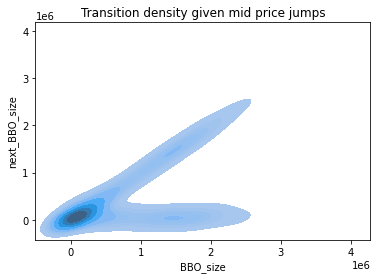

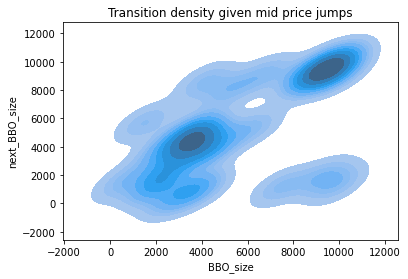

In [12]:
import seaborn as sns
df['tot_size'] = df['as'] + df['bs']
df['next_tot_size'] = df['next_as'] + df['next_bs']
view = df[(~df['mirrored']) & (df['dM']!=0.0)]
plt.figure()
sns.kdeplot(data=view, x='tot_size', y='next_tot_size', fill=True)
plt.title('Transition density given mid price jumps')
plt.xlabel('BBO_size')
plt.ylabel('next_BBO_size')

view2 = df[(~df['mirrored']) & (df['dM']!=0.0) & (df['tot_size']<1.0e4) & (df['next_tot_size']<1.0e4)]
plt.figure()
sns.kdeplot(data=view2, x='tot_size', y='next_tot_size', fill=True, bw_adjust=0.5)
plt.title('Transition density given mid price jumps')
plt.xlabel('BBO_size')
plt.ylabel('next_BBO_size')

## next_spread | \{next_spread, mid↑or↓\}

Text(0, 0.5, 'next_spread')

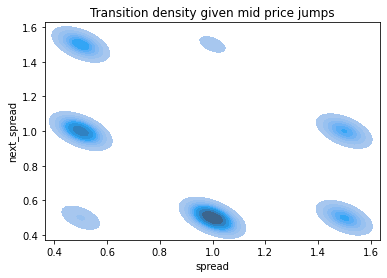

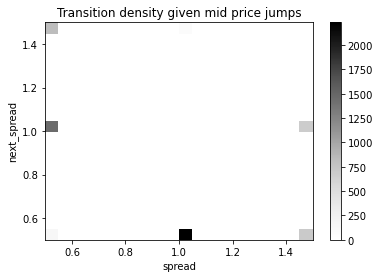

In [13]:
view = df[(~df['mirrored']) & (df['dM']!=0.0)]
plt.figure()
sns.kdeplot(data=view, x='spread', y='next_spread', fill=True, bw_adjust=0.5)
plt.title('Transition density given mid price jumps')


x = view['spread']
y = view['next_spread']

fig, ax = plt.subplots()
h = ax.hist2d(x, y, bins=20, density=False, cmap='Greys')#plt.cm.jet
fig.colorbar(h[3], ax=ax)
plt.title('Transition density given mid price jumps')
plt.xlabel(x.name)
plt.ylabel(y.name)

In [14]:
view = df[(~df['mirrored']) & (df['dM']!=0.0)]
print(view['spread'].value_counts())
view[['spread', 'next_spread']].groupby('spread').mean()

0.5    2449
1.0    2310
1.5    1402
Name: spread, dtype: int64


,next_spread
spread,
0.5,1.139649
1.0,0.533333
1.5,0.749643


## Combine Trades With Quotes

### Load trades

In [15]:
import pickle
def load_trds():
    data = []
    with open(r'XBTUSD-trades.pickle', 'rb+') as f_hnd:
        try:
            while True:
                dd = pickle.load(f_hnd)
                subset = {key:dd.get(key) for key in ['timestamp', 'side', 'size', 'price', 'tickDirection']}
                data.append(subset)
        except EOFError:
            print('End of File')
        return data

df_trds = pd.DataFrame(load_trds())
df_trds['timestamp'] = pd.to_datetime(df_trds['timestamp']).dt.tz_localize(None)
df_trds

End of File


,timestamp,side,size,price,tickDirection
0,2020-12-14 00:07:24.491,Buy,1000,19077.5,PlusTick
1,2020-12-14 00:07:25.080,Sell,5000,19077.0,MinusTick
2,2020-12-14 00:07:25.615,Sell,1100,19077.0,ZeroMinusTick
3,2020-12-14 00:07:26.298,Sell,45,19077.0,ZeroMinusTick
4,2020-12-14 00:07:28.223,Sell,10000,19077.0,ZeroMinusTick
...,...,...,...,...,...
73718,2020-12-14 10:25:51.686,Buy,6000,19185.0,ZeroPlusTick
73719,2020-12-14 10:25:59.152,Sell,1,19184.5,MinusTick
73720,2020-12-14 10:26:16.011,Buy,1,19185.0,PlusTick
73721,2020-12-14 10:26:16.703,Sell,12,19184.5,MinusTick


In [16]:
#df_trds['bb_id'] = (df_trds[ df_trds['side'] =='Sell']['price'].diff() != 0.0).cumsum().astype(int)
#df_trds['bo_id'] = (df_trds[ df_trds['side'] =='Buy' ]['price'].diff() != 0.0).cumsum().astype(int)
#df_trds[df_trds.side == 'Buy']

### (Re)load quotes

In [17]:
ticker = 'XBTUSD'
df = iodata.get_df(ticker)
# Time resolution is 1ms, so duplicate might occur, keep last.
df = df[~df.index.duplicated(keep='last')]
df['time'] = df['time'].dt.tz_localize(None)
df.index = df.index.tz_localize(None)

### Assign trades to previous LOB event
LOB event at time $t$ will be hit by MO occuring at time s if $t<s<=(t+1)$

**TODO**: Do this directly using merging

In [18]:
import numba
@numba.njit
def assign_bucket(vals, bkts):
    out = np.empty(len(vals), dtype='int')
    i1 = 0
    i2 = 0
    while i1 < len(vals) and i2 < len(bkts)-1:
        #print(i1,vals[i1],i2, bkts[i2])
        if bkts[i2] < vals[i1]:
            if vals[i1] < bkts[i2+1]:
                out[i1] = i2
                i1 += 1
            else:
                i2 += 1
        else:
            out[i1] = -1
            i1 += 1
    out[i1::] = -1
    return out
            
    
#df_sales = pd.DataFrame({'time':[0.5,2,6,7,9,15], 'soldCount':[1, 1,2,3,4,5]})
#df_checkpoints = pd.DataFrame({'time':[1,5,10], 'shift':['Adam','Ben','Carl']})
#bla(df_sales['time'].to_numpy(), df_checkpoints['time'].to_numpy())
        
buckets = assign_bucket(df_trds['timestamp'].to_numpy(), df['time'].to_numpy())
df_trds['lob_bkt'] = buckets
df['lob_bkt'] = np.arange(df.shape[0])
df_trds = df_trds[df_trds['lob_bkt'] > -1]

In [19]:
#q1 = df_trds.groupby(['lob_bkt'])['price'].agg(['first', 'last'])
#q1[q1['first'] != q1['last']]

### Merge quotes with trade volume

In [20]:
df_agg = df_trds.groupby(['lob_bkt', 'side']).agg({'size':'sum'}).unstack('side').fillna(0)
df_agg.columns = df_agg.columns.map(''.join)
lb, ub  = df_agg.index.min(), df_agg.index.max() - 1 # remove open ended tail
df_mgd = pd.merge(df, df_agg, left_on='lob_bkt', right_index=True, how='left')
df_mgd = df_mgd[(lb <= df_mgd['lob_bkt']) & (df_mgd['lob_bkt'] <= ub)]
df_mgd[['sizeBuy', 'sizeSell']] = df_mgd[['sizeBuy', 'sizeSell']].fillna(value=0.0)
df_mgd.reset_index(inplace=True)

In [21]:
df_mgd.iloc[0].T

timestamp    2020-12-14 00:07:29.441000
bs                             307901.0
bid                             19077.0
ask                             19077.5
as                             861914.0
time         2020-12-14 00:07:29.441000
mid                            19077.25
sprd                               0.25
imb                            0.263205
wmid                       19077.131602
lob_bkt                              91
sizeBuy                             0.0
sizeSell                         5451.0
Name: 0, dtype: object

### Look at when wither bid or ask changes, or both.

In [22]:
look_at = 'bbo_id'

#df_trds['bb_id'] = (df_trds[ df_trds['side'] =='Sell']['price'].diff() != 0.0).cumsum().astype(int)
df_mgd['bb_id'] = (df_mgd['bid'].diff() != 0.0).cumsum().astype(int)
df_mgd['bo_id'] = (df_mgd['ask'].diff() != 0.0).cumsum().astype(int)
df_mgd['bbo_id'] = ((df_mgd['bid'].diff() != 0.0) | (df_mgd['ask'].diff() != 0.0)).cumsum().astype(int)
# BB and trades until changed.
sub_events = df_mgd.groupby([look_at]).agg({'time':'first', 'sizeSell':'sum', 'sizeBuy':'sum','bid':'first', 'bs':'first', 'ask':'first', 'as':'first', 'imb':'first'})

sub_events['relBid'] = sub_events['sizeSell'] / sub_events['bs']
sub_events['relAsk'] = sub_events['sizeBuy'] / sub_events['as']
print(f"E(BidTurnover) = {sub_events['relBid'].mean():.2f}")
print(f"P(BidTurnover=0) = {(sub_events['relBid']==0).mean():.3f}")
print(f"E(BidTurnover|>0) = {sub_events[sub_events['relBid']>0]['relBid'].mean():.2f}")
print('')
print(f"E(AskTurnover) = {sub_events['relAsk'].mean():.2f}")
print(f"P(AskTurnover=0) = {(sub_events['relAsk']==0).mean():.3f}")
print(f"E(AskTurnover|>0) = {sub_events[sub_events['relAsk']>0]['relAsk'].mean():.2f}")

E(BidTurnover) = 0.23
P(BidTurnover=0) = 0.998
E(BidTurnover|>0) = 111.73

E(AskTurnover) = 0.00
P(AskTurnover=0) = 1.000
E(AskTurnover|>0) = 0.11


            bid       bs  sizeSell      ask         as  sizeBuy
502907  19195.0    987.0       0.0  19195.5    69656.0      0.0
502908  19195.0    987.0       0.0  19195.5    71556.0      0.0
502909  19195.0    987.0       0.0  19195.5    75709.0      0.0
502910  19195.0    987.0    2000.0  19195.5   125710.0      0.0
502911  19195.0    987.0       0.0  19195.5   147541.0      0.0
...         ...      ...       ...      ...        ...      ...
503056  19195.0  10987.0       0.0  19195.5  1734139.0      0.0
503057  19195.0  10987.0       0.0  19195.5  1734128.0      0.0
503058  19195.0  10987.0       0.0  19195.5  1734116.0      0.0
503059  19195.0  10987.0       0.0  19195.5  1734104.0      0.0
503060  19192.5    400.0       0.0  19195.5  1734104.0      0.0

[154 rows x 6 columns]
Turnover 166.3
PostDeltaBid = -2.5
PostDeltaAsk = -0.5


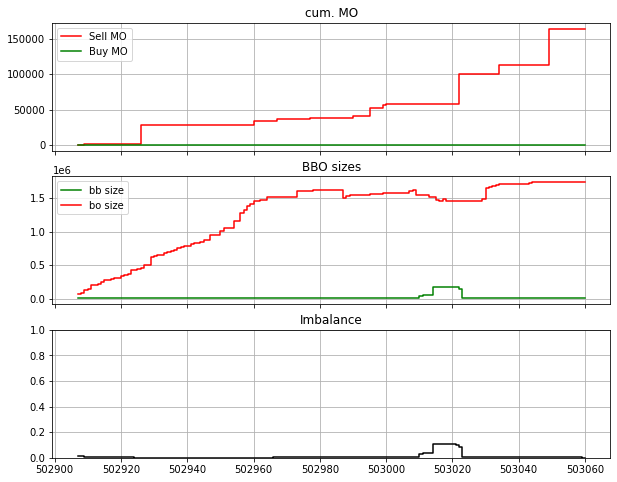

In [23]:
kth = 3
idx = sub_events['relBid'].nlargest(kth).iloc[[-1]].index[0]
inst = sub_events['relBid'].nlargest(kth).iloc[[-1]]
idx = inst.index[-1]
turnover = inst.iloc[-1]

obs = df_mgd[df_mgd[look_at].between(idx, idx+1)]
print(obs[['bid', 'bs', 'sizeSell', 'ask', 'as', 'sizeBuy']])

fig, axs = plt.subplots(3,1, figsize=(10,8), sharex=True)
axs[0].set_title('cum. MO')
axs[0].step(obs.index, obs['sizeSell'].cumsum(), color='r', label='Sell MO')
axs[0].step(obs.index, obs['sizeBuy'].cumsum(), color='g', label='Buy MO')
axs[0].legend(); axs[0].grid()

axs[1].set_title('BBO sizes')
axs[1].step(obs.index, obs['bs'], color='g', label='bb size')
axs[1].step(obs.index, obs['as'], color='r', label='bo size')
axs[1].legend(); axs[1].grid()

axs[2].set_title('Imbalance')
axs[2].step(obs.index, obs['imb'], color='k')
axs[2].set_ylim([0, 1]); axs[2].grid()


next_bid = df_mgd.loc[obs.index[-1]+1]
bidChange = next_bid['bid'] - obs['bid'].iloc[0]
askChange = next_bid['ask'] - obs['ask'].iloc[0]
print(f'Turnover {turnover:.1f}')
print(f'PostDeltaBid = {bidChange}')
print(f'PostDeltaAsk = {askChange}')

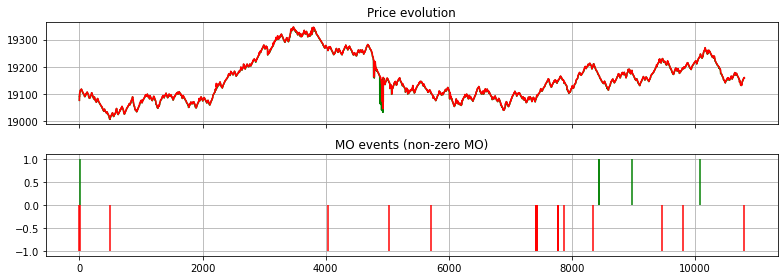

In [24]:
fig, axs = plt.subplots(2, 1, figsize=(11,4), sharex=True)
axs[0].plot(sub_events['bid'], color='g'); axs[0].set_title('Price evolution')
axs[0].plot(sub_events['ask'], color='r')
#axs[1].plot(sub_events['ask']-sub_events['bid'], color='r'); axs[1].set_title('Spread')
#axs[1].plot(sub_events['imb'], color='k')
#axs[2].plot(sub_events['relBid'])
#axs[3].plot(sub_events['relAsk'])
axs[1].set_title('MO events (non-zero MO)')
axs[1].vlines(range(sub_events.shape[0]), 0, +sub_events['relAsk']>0, color='g', label='MO Buy')
axs[1].vlines(range(sub_events.shape[0]), -1*(sub_events['relBid']>0), 0, color='r', label='MO Sell')

for ax in axs:
    ax.grid()
fig.tight_layout()